In [1]:
import sys
sys.path.append('../')
sys.path.append('../support/')
sys.path.append('../lung_segmentation/')

from preprocessing import *
from ct_reader import *
import pandas as pd
from os.path import join, basename, isfile
from scipy.ndimage.interpolation import zoom
from glob import glob
from multiprocessing import Pool
from scipy.ndimage import morphology
from scipy.ndimage import label
from skimage import measure
from tqdm import tqdm
from multiprocessing import Pool
import pickle
%pylab inline
from paths import * 
from skimage.transform import resize
import warnings
# warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [5]:
a = pd.read_csv(join(PATH['CSV'], 'anotations.csv'))

OSError: File b'/home/a.dobrenkii/Projects/Kaggle/DataScienceBowl2K17/data/CSV/anotations.csv' does not exist

In [17]:
a = pd.read_csv('/home/a.dobrenkii/Projects/Kaggle/DataScienceBowl2K17/data/LUNA/annotations.csv')

In [20]:
percentile(a.diameter_mm, 80)

11.066297479999999

In [22]:
(42**3) / (3.14 * 6**3)

109.23566878980891

In [2]:
BORDER = 32
BATCH_SIZE = 32
OUT_LUNGS = -9000
SPACING = array([.9, .7, .7])
UPSIDES = pickle.load(open(join(PATH['WEIGHTS'], 
                                'upsides'), 'rb'))
CPU = 24

In [ ]:

def apply_enhs_filters(mask, patient, include_plane=False):
    enhs = []
    sigmas = get_scales()
    _enh_dot = zeros(mask.shape)
    _enh_line = zeros(mask.shape)

    z_dot = list()
    z_line = list()
    divs = list()

    for i, sigma in enumerate(sigmas):

        filtered = gaussian_filter(patient, sigma=sigma)
        grad = gradient(filtered * mask)

        axis = [[0, 1, 2], [1, 2], [2]]
        hess = [gradient(deriv, axis=j) 
                for i, deriv in enumerate(grad) 
                for j in axis[i]]

    #   [(0, xx), (1, xy), (2, xz), (3, yy), (4, yz), (5, zz)]
    #   x, y, z -> 3, 3, x, y, z -> 3, 3, N

        coords = where(mask)
        for j in range(len(hess)):
            hess[j] = hess[j][coords]

        hess = asarray([[hess[0], hess[1], hess[2]],
                        [hess[1], hess[3], hess[4]],
                        [hess[2], hess[4], hess[5]]])


        with Pool(CPU) as pool:
            eigs = pool.map(linalg.eigvalsh, [hess[:, :, i] for i in range(hess.shape[-1])])

        sigma_sqr = sigma ** 2
        z_dot.append([sigma_sqr * (eig_val[2] ** 2) / abs(eig_val[0]) 
                      if eig_val[0] < 0 
                      and eig_val[1] < 0 
                      and eig_val[2] < 0 
                      else 0
                      for eig_val in eigs])

        z_line.append([sigma_sqr * abs(eig_val[1]) 
                       * (abs(eig_val[1]) - abs(eig_val[2])) 
                       / abs(eig_val[0]) 
                       if eig_val[0] < 0 
                       and eig_val[1] < 0 
                       else 0
                       for eig_val in eigs])

        _enh_dot[coords] = asarray(z_dot).max(axis=0)
        _enh_line[coords] = asarray(z_line).max(axis=0)
        enhs.append((_enh_dot, _enh_line))
    return enhs

In [3]:
def read_ct(path, ret_xy_spacing=False, ret_original_format=True):
    patient = read_ct_scan(path)
    image = get_pixels_hu(patient)
#     image[image == image[0,0,0]] = 0
    
    if ret_original_format:
        return image, patient
    
    if ret_xy_spacing:
        return image, patient.GetSpacing()[0]
    
    return image

In [4]:
def segment_nodules(patch, mask, is_nodule=True, magic_const=50):
    prepared = (patch - patch.min()) / (patch.max() - patch.min())

    kmeans = KMeans(n_clusters=2)
    data = prepared[coords]
    
    if data.shape[0] <= 2:
        return mask
    
    data = kmeans.fit_predict(expand_dims(data, 1))

    kmean = zeros(mask.shape)
    kmean[coords] = data + magic_const
    labels, num = label(kmean, return_num=True, background=0)

    nodule_a = argmax([sum(labels == i) for i in range(1, num + 1)]) + 1
    init = kmeans.predict(expand_dims(prepared[labels == nodule_a], 1)).min()
    nodule_b = list()
    for i in range(1, num + 1):
        if i != nodule_a:
            if kmeans.predict(expand_dims(prepared[where(labels == i)], 1)).min() != init:
                nodule_b.append((sum(labels == i), i))

    nodule_b = max(nodule_b)[1]

    A = prepared[labels == nodule_a]
    B = prepared[labels == nodule_b]

    if mean(A.reshape(-1)) > mean(B.reshape(-1)):
        labels = labels == nodule_a
    else:
        labels = labels == nodule_b

    return labels

In [192]:
def overlap(lung, mask):
#     iso = binary_dilation(imresize(isolated[163], (512, 512)))
    labeled, num = label(mask)
    coords = list()
    for colour in range(1, labeled.max() + 1):
        coords.append(where(labeled == colour))
        
    coords = array([[int(coord[0].mean())
                     for coord in coords], 
                    [int(coord[1].mean())
                     for coord in coords],
                    [int(coord[2].mean())
                     for coord in coords]])
    
    pads = ((BORDER, BORDER), 
            (BORDER, BORDER), 
            (BORDER, BORDER))
    
    lung = pad(lung, pads, 
               mode='edge')
    res = zeros(lung.shape)
    labeled = pad(labeled, pads, 
                  mode='edge')
    patches = list()
    masks = list()
    for coord in coords.T:
        res[coord[0]: coord[0] + 2 * BORDER,
            coord[1]: coord[1] + 2 * BORDER,
            coord[2]: coord[2] + 2 * BORDER] += \
            segment_nodule(lung[coord[0]: coord[0] + 2 * BORDER,
                                coord[1]: coord[1] + 2 * BORDER,
                                coord[2]: coord[2] + 2 * BORDER],
                           labeled[coord[0]: coord[0] + 2 * BORDER,
                                   coord[1]: coord[1] + 2 * BORDER,
                                   coord[2]: coord[2] + 2 * BORDER])

    return res[BORDER: -BORDER,
               BORDER: -BORDER,
               BORDER: -BORDER]

In [178]:
def region_growing(img, seed, minthr, maxthr, structure=None):
    """code was taken from:
    https://github.com/loli/medpy/wiki/Basic-image-manipulation
    """
    img[seed] = minthr
    thrimg = (img <= maxthr) & (img >= minthr)
    lmap, _ = label(thrimg, structure=structure)
    lids = unique(lmap[seed])
    region = zeros(img.shape, numpy.bool)
    for lid in lids:
        region |= lmap == lid
    return region

In [201]:
def operate(path):
    lung, ct_lung = read_ct(path, ret_original_format=True)
    
    lung, spacing = resample(lung, ct_lung, (1, 1, 1))
    
    name = basename(path)
    mask = load(join(PATH['DATA_ENHANCED'], 
                         name + '.npy'))
    lung_mask = load(join(PATH['DATA_OUT'], 
                              name + '.npy'))
    lung += OUT_LUNGS * (lung_mask == 0)
#     mask, spacing = resample(mask, (1, 1, 1), SPACING)
    
    if name in UPSIDES:
        lung = flipud(lung)
        mask = flipud(mask)
    
    lung_mask = (lung_mask // 8) * 2 + overlap(lung, mask)
    save(join(PATH['DATA_OUT'], 
                              name + '.npy'), lung_mask)
    return name

In [202]:
def segment_nodule(btch,mask):
    batch = btch.copy()
    interval = [64, 64]
    grown = [mask == find_closest_label(batch,mask)] * 2
    minval = median(batch[grown[-1]])
    maxval = median(batch[grown[-1]])
    sums = [grown[0].sum()] * 2
    while True: #unique((mask == mask[32][32]) == grown).shape[0] == 1:
        grown.append(region_growing(batch, 
                                    grown[-1], 
                                    minval, 
                                    maxval))
        minval -= interval[0]
        maxval += interval[1]
        grown.pop(0)
        sums.append(grown[-1].sum())
        sums.pop(0)
        if 2 * sums[0] < sums[1]:
            interval[0] = interval[0] // 2
            interval[1] = interval[1] // 2
            grown = [grown[0]] * 2
            sums = [grown[0].sum()] * 2
            if interval[0] == 1:
                break
        if grown[0].sum() > 27000:
            break
    return grown[0]

In [203]:
def find_closest_label(lung, enh):
    center = zeros(lung.shape)
    center[lung.shape[0] // 2, lung.shape[1] // 2, lung.shape[2] // 2] = 1
    ans = (enh * center).max()
    while ans == 0:
        center = morphology.binary_dilation(center)
        ans = (enh * center).max()
    return ans

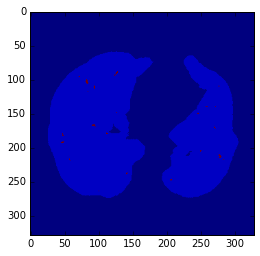

In [21]:
a = load(join(PATH['STAGE_MASKS'], '007c1246c5fe6f200378f6b91323dc2a.npy'))
# a = load(join(PATH['STAGE_ENHANCED'], '007c1246c5fe6f200378f6b91323dc2a.npy'))
imshow(a[a.shape[0] // 2 + 25])

In [23]:
l, _ = label(a >= 16)
print(sorted(bincount(l.flatten())[1:], reverse=True)[:20])

[599, 365, 221, 220, 219, 215, 210, 185, 184, 180, 176, 160, 157, 153, 133, 133, 130, 127, 121, 113]


In [20]:
l, _ = label(a)
print(sorted(bincount(l.flatten())[1:], reverse=True)[:20])

[435, 313, 181, 173, 171, 156, 152, 144, 141, 128, 126, 121, 120, 108, 99, 96, 88, 80, 78, 78]


In [204]:
def get_remind_files():
    file_list = set(glob(join(PATH['DATA'], '*')))
#     file_list = file_list.difference(set([join(PATH['DATA'], basename(path).split('.npy')[0][:32]) 
#                             for path in glob(join(PATH['ENHANCED_CROPPED'], '*.npy'))]))
    return sorted(list(file_list))

In [195]:
file_list = get_remind_files()
with Pool(CPU) as pool:
    processed = pool.map(operate, file_list)
pickle.dump(processed, open(join(PATH['WEIGHTS'], 'processed_grown_nodules'), 'wb'))
# for file in file_list:
    
# #     batch_files = file_list[BATCH_SIZE * counter:
# #                             BATCH_SIZE * (counter + 1)]

# #     nodule_mask, lung, lung_mask = operate(batch_files[0])
    
# #     print('1 finished')
# #     nodule_mask, lung = operate(batch_files[0])
# #     nodule_masks.append(nodule_mask)
# #     lungs.append(lung)
#     break


  0%|          | 0/50 [00:00<?, ?it/s]


1 finished
